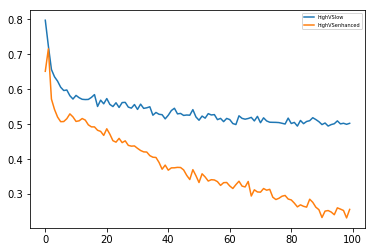

In [2]:
import os
import sys
dir_path = "/Users/neda/HiCPlus_pytorch/src"

import numpy as np
import argparse
import cooler
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr
model_path = dir_path + "/models"
utils_path = dir_path + "/utils"
sys.path.insert(0, model_path)
sys.path.insert(0, utils_path)
import model2
import utils

"""
ap = argparse.ArgumentParser()
ap.add_argument("--low_res_cool_path", required = True, help = "path of cool file need to be enhanced")
ap.add_argument("--high_res_cool_path", required = True, help = "path of high resolution cool file to compare with enhanced data if applicable")
ap.add_argument("--output_enhanced_cool_path", help = "path of output cool file to be saved") #default: where the input file was
ap.add_argument("--learned_model_path", required = True, help = "path of learned model for corresponding down sample ratio")
ap.add_argument("--resolution", required = True, help = "resolution size of HiC contact matrix", default = "10000")
args = vars(ap.parse_args())
"""
args = {"low_res_cool_path": "/Users/neda/prostate-samples/PCa13266.multi-res.cool"
       , "high_res_cool_path": "/Users/neda/prostate-samples/HighRes-PCa13266.multi-res.cool"
       , "learned_model_path": "/Users/neda/HiCPlus_pytorch/src/learned-networks/PCa13266-res10000(up-wo-min)(rand-down)"
        #"/Users/neda/HiCPlus_pytorch/src/learned-networks/down16-res10000(up-wo-min)"
        
       , "resolution": "10000"}
Net = model2.Net(40, 36)
Net.load_state_dict(torch.load(args['learned_model_path']))
Net = Net.float()
cool_path = args['low_res_cool_path'] + "::/resolutions/" + args['resolution']
c = cooler.Cooler(cool_path)
high_cool_path = args['high_res_cool_path'] + "::/resolutions/" + args['resolution']
c2 = cooler.Cooler(high_cool_path)
for chrNu in [17]:
    chrN = chrNu + 1
    #chr_mat = c.matrix(balance = False).fetch("chr" + str(chrN))
    #chr_mat[np.isnan(chr_mat)] = 0
    low_res_path = "/Users/neda/prostate-samples/PCa13266-down/chr18.txt_npy_form_tmp.npy"
    chr_mat = np.load(low_res_path)
    low_resolution_samples, indices = utils.divide2(chr_mat, chrN)
    low_resolution_samples = np.stack(low_resolution_samples, axis = 0)
    indices = np.stack(indices, axis = 0)
    low_resolution_samples = np.expand_dims(low_resolution_samples, axis=1)
    lowres_set = torch.from_numpy(low_resolution_samples).float()
    high_chr_mat = c2.matrix(balance = False).fetch("chr" + str(chrN))
    high_chr_mat[np.isnan(high_chr_mat)] = 0
    enhanced_set = Net(Variable(lowres_set))
    enhanced_set = enhanced_set.data.cpu().numpy()
    enhanced_set = np.reshape(enhanced_set, (enhanced_set.shape[0], enhanced_set.shape[2], enhanced_set.shape[3]))
    enhanced_chr_mat = np.load(low_res_path)
    for i in range(indices.shape[0]):
        x_pos = indices[i,1]
        y_pos = indices[i,2]
        enhanced_chr_mat[x_pos+2:x_pos+38,y_pos+2:y_pos+38] = enhanced_set[i,:,:]
    iu = np.triu_indices(enhanced_chr_mat.shape[0],1)
    il = (iu[1],iu[0])
    enhanced_chr_mat[il]=enhanced_chr_mat[iu]
    #average_chr_mat = c.matrix(balance = False).fetch("chr" + str(chrN))
    #average_chr_mat[np.isnan(average_chr_mat)] = 0
    #chr_length = average_chr_mat.shape[0]
    #chr_mat2 = np.zeros((chr_length+6,chr_length+6))
    #chr_mat2[3:chr_length+3,3:chr_length+3] = chr_mat
    #print(chr_mat2.shape)
    #for i1 in range(chr_length):
     #   for i2 in range(chr_length):
     #       average_chr_mat[i1,i2] = np.mean(chr_mat2[i1:i1+6,i2:i2+6])
    def vec_of_dist(matrix, x):
        return([matrix[i,i+x] for i in range(matrix.shape[1]-x)])

    highVSlow_corr_list = []
    highVSenhanced_corr_list = []
    highVSaverage_corr_list = []
    for dist in range(100):
        low_res_vec = vec_of_dist(chr_mat, dist)
        high_res_vec = vec_of_dist(high_chr_mat, dist)
        enhanced_vec = vec_of_dist(enhanced_chr_mat, dist)
        #average_vec = vec_of_dist(average_chr_mat, dist)
        highVSlow_corr_list.append(spearmanr(low_res_vec, high_res_vec)[0])
        #highVSaverage_corr_list.append(spearmanr(average_vec, high_res_vec)[0])
        highVSenhanced_corr_list.append(spearmanr(high_res_vec, enhanced_vec)[0])
    plt.plot(highVSlow_corr_list, label = "highVSlow")
    plt.plot(highVSenhanced_corr_list, label = "highVSenhanced")
    #plt.plot(highVSaverage_corr_list, label = "highVSaverage")
    plt.legend(loc='upper right', prop={'size': 5})
    plt.show()
    

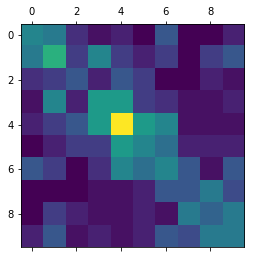

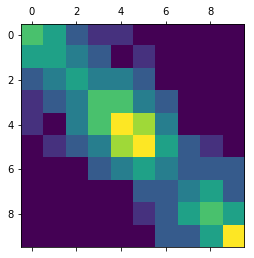

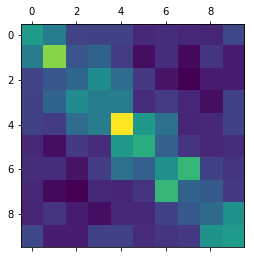

In [3]:
lb=2200
ub = 2210
plt.matshow(chr_mat[lb:ub,lb:ub])
plt.matshow(enhanced_chr_mat[lb:ub,lb:ub])
plt.matshow(high_chr_mat[lb:ub,lb:ub])

In [4]:
lb=2200
ub = 2210
print(chr_mat[lb:ub,lb:ub])
print(enhanced_chr_mat[lb:ub,lb:ub])
print(high_chr_mat[lb:ub,lb:ub])

[[10  9  3  1  2  0  6  0  0  2]
 [ 9 14  4 10  4  2  4  0  4  6]
 [ 3  4  6  2  6  4  0  0  2  1]
 [ 1 10  2 12 12  4  3  1  1  2]
 [ 2  4  6 12 22 12 10  1  1  1]
 [ 0  2  4  4 12 10  8  2  2  2]
 [ 6  4  0  3 10  8 10  6  1  6]
 [ 0  0  0  1  1  2  6  6  9  5]
 [ 0  4  2  1  1  2  1  9  7  9]
 [ 2  6  1  2  1  2  6  5  9  9]]
[[7 6 4 3 3 2 2 2 2 2]
 [6 6 5 4 2 3 2 2 2 2]
 [4 5 6 5 5 4 2 2 2 2]
 [3 4 5 7 7 5 4 2 2 2]
 [3 2 5 7 9 8 5 2 2 2]
 [2 3 4 5 8 9 6 4 3 2]
 [2 2 2 4 5 6 5 4 4 4]
 [2 2 2 2 2 4 4 5 6 4]
 [2 2 2 2 2 3 4 6 7 6]
 [2 2 2 2 2 2 4 4 6 9]]
[[47 37 20 19 19 13 14 13 12 21]
 [37 68 25 29 18  7 14  6 16 10]
 [20 25 30 42 32 17  8  4 10 10]
 [19 29 42 37 37 14 18 13  7 19]
 [19 18 32 37 82 46 33 12 13 19]
 [13  7 17 14 46 53 28 16 13 14]
 [14 14  8 18 33 28 43 56 19 16]
 [13  6  4 13 12 16 56 29 26 17]
 [12 16 10  7 13 13 19 26 31 44]
 [21 10 10 19 19 14 16 17 44 47]]


In [5]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(chr_mat[lb:ub,lb:ub].flatten(), high_chr_mat[lb:ub,lb:ub].flatten()))
print(rmse(high_chr_mat[lb:ub,lb:ub].flatten(), enhanced_chr_mat[lb:ub,lb:ub].flatten()))
print(rmse(chr_mat[lb:ub,lb:ub].flatten(), average_chr_mat[lb:ub,lb:ub].flatten()))
print(rmse(high_chr_mat[lb:ub,lb:ub].flatten(), average_chr_mat[lb:ub,lb:ub].flatten()))

21.449708622729588
22.868537338448213


NameError: name 'average_chr_mat' is not defined

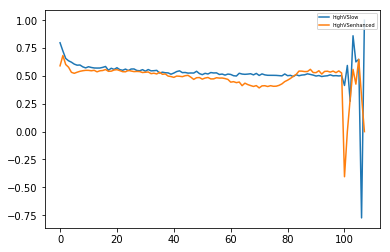

In [70]:
for dist in range(10):
        low_res_vec = vec_of_dist(chr_mat[lb:ub,lb:ub], dist)
        high_res_vec = vec_of_dist(high_chr_mat[lb:ub,lb:ub], dist)
        enhanced_vec = vec_of_dist(enhanced_chr_mat[lb:ub,lb:ub], dist)
        #average_vec = vec_of_dist(average_chr_mat, dist)
        highVSlow_corr_list.append(spearmanr(low_res_vec, high_res_vec)[0])
        #highVSaverage_corr_list.append(spearmanr(average_vec, high_res_vec)[0])
        highVSenhanced_corr_list.append(spearmanr(high_res_vec, enhanced_vec)[0])
plt.plot(highVSlow_corr_list, label = "highVSlow")
plt.plot(highVSenhanced_corr_list, label = "highVSenhanced")
#plt.plot(highVSaverage_corr_list, label = "highVSaverage")
plt.legend(loc='upper right', prop={'size': 5})
plt.show()
